In [1]:
################################ EDA IMPORTS ###################################
%matplotlib inline
import pandas as pd 
import numpy as np # Linear Algebra lib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
# Pick style of Matplolib plots 
# Different style sheets:-> https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
# Configure Seaborn Asthetics: -> https://seaborn.pydata.org/tutorial/aesthetics.html?highlight=style
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')
# Seting a universal figure size 
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150

# ---------------- Pandas settings ------------- #
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

################################################################################

#################################### ML IMPORTS ################################
### Pre-Processing
import category_encoders as ce

### Train/Test - Split & CV
from sklearn.model_selection import train_test_split

### Regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Pipeline
from sklearn.pipeline import make_pipeline

### Feature Importance
import eli5
from eli5.sklearn import PermutationImportance

### Tuning Hyperparameters
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

### Model Interpretabilit
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap


##############################################################################

#################################### CUSTOM API IMPORTS #######################
import sys, os
sys.path.insert(len(sys.path)-1, os.path.dirname(os.getcwd()))
from pubg import helper
from pubg import eda
###############################################################################

# Project PUBG 🤖💣💥🔫🤖 

![](https://o.aolcdn.com/images/dims?quality=100&image_uri=http%3A%2F%2Fo.aolcdn.com%2Fhss%2Fstorage%2Fmidas%2Fb0be09f425cc5175fb413bc03c32dd0d%2F206235889%2Fpubg-ed.jpg&client=amp-blogside-v2&signature=88c6b77342cbeb0d25c0dc9d909018136aec1971)

### Load Dataset

In [2]:
def download_clean_data_from_s3():
    !rm -rf '../datasets/clean-data'
    !mkdir -p '../datasets/clean-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/clean-data/train.csv' -P '../datasets/clean-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/clean-data/validate.csv' -P '../datasets/clean-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/clean-data/test.csv' -P '../datasets/clean-data'
download_clean_data_from_s3()

--2019-08-30 07:38:38--  https://project-pubg.s3.us-east-2.amazonaws.com/clean-data/train.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.104.40
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.104.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46172999 (44M) [text/csv]
Saving to: ‘../datasets/clean-data/train.csv’

train.csv           100%[===================>]  44.03M  49.1MB/s    in 0.9s    

2019-08-30 07:38:39 (49.1 MB/s) - ‘../datasets/clean-data/train.csv’ saved [46172999/46172999]

--2019-08-30 07:38:39--  https://project-pubg.s3.us-east-2.amazonaws.com/clean-data/validate.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.104.40
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.104.40|:443... connected.
HTTP request sent, awaiting 

In [3]:
train = helper.load_dataset('../datasets/clean-data/train.csv')
val = helper.load_dataset('../datasets/clean-data/validate.csv')
test = helper.load_dataset('../datasets/clean-data/test.csv')

train.head()

Memory usage of dataframe is 53.41 MB
Memory usage after optimization is: 18.84 MB
Decreased by 64.7%

        -------------------- SHAPE ---------------------
        DF train.csv: (250007, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 17.80 MB
Memory usage after optimization is: 6.20 MB
Decreased by 65.2%

        -------------------- SHAPE ---------------------
        DF validate.csv: (83340, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 17.80 MB
Memory usage after optimization is: 6.28 MB
Decreased by 64.7%

        -------------------- SHAPE ---------------------
        DF test.csv: (83335, 28)
        ------------------------------------------------
        


,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
0,0,0,2,22.4375,byplayer,1815,solo,0,4,50,0,0,0.000000,Baltic_Main,d79eab0b-4362-4194-8d53-d3187f434040,kakao,80092d0a24be4de3a6a8f7cad3fb2533,0,0.0,0,120.9375,0,1063.000,0,2886.000,5,97,0.687500
1,1,0,3,196.5000,byplayer,1885,squad,1,0,25,1,1,14.187500,Erangel_Main,8999923b-7898-4c5b-8a47-ff4ef2a9a553,psn,93f8cfbe811449898a5a31766b3a7199,0,0.0,0,0.0000,0,1411.000,0,2548.000,6,27,0.692383
2,2,0,8,183.7500,byplayer,1902,squad,0,2,8,2,3,25.078125,Desert_Main,339299e8-271b-41d9-91e0-3e86da67a7a1,steam,633c67b7a9654986bb5e6080bd091d9,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2,21,0.399902
3,0,0,0,0.0000,byplayer,1457,squad-fpp,0,0,89,0,0,0.000000,Savage_Main,29e18b9f-218f-4b47-a71e-6197cf4c7998,steam,f127a12617406f93ac66e8ee3e5c48,0,0.0,0,0.0000,0,100.750,0,37.250,2,29,0.035706
4,0,0,0,0.0000,byplayer,1422,duo,0,0,78,0,0,0.000000,Savage_Main,3279c5e8-9bb7-4444-a1d4-98b2ed5b6fa8,kakao,41f3f774292541a58955eb5d1bf294c3,0,0.0,0,0.0000,0,206.375,0,143.625,2,49,0.250000


## Outlier Analysis

Drop outliers noted in notebook 1 earlier

- high no. of damage dealt
- high no. of heals
- high no. of revives
- high no. of weapons picked up
- high walkdistance, no kills
- high ridedistance, no kills

In [4]:
def remove_outliers(df):
    
    # Make Copy
    df = df.copy()
    
    # Not possible to have really high damage given the limitations of the game
    mask = (df['damageDealt'] > 2500)
    df = df[~mask]
    
    # Copious amounts of healing items used
    mask = (df['heals'] > 50)
    df = df[~mask]
    
    # Very unusal no .of revives
    mask = (df['revives'] > 15)
    df = df[~mask]
    
    # Obvious cheaters
    mask = (df['weaponsAcquired'] > 20)
    df = df[~mask] 

    # Riding Trolls
    mask = (df['rideDistance'] > 15000) & (df['kills'] == 0)
    df = df[~mask]
    
    # Peace lovers
    mask = (df['walkDistance'] > 10000) & (df['kills'] == 0)
    df = df[~mask]
    
    return df.reset_index(drop=True)

In [5]:
eda.print_shape(train, val, test, title='BEFORE: Train/Validate/Test')
train = remove_outliers(train)
val = remove_outliers(val)
test = remove_outliers(test)
eda.print_shape(train, val, test, title='AFTER: Train/Validate/Test')

------- SHAPE - BEFORE: Train/Validate/Test ---------
Training Set: (250007, 28)
Validation Set: (83340, 28)
Testing Set: (83335, 28)
------- SHAPE - AFTER: Train/Validate/Test ---------
Training Set: (249943, 28)
Validation Set: (83322, 28)
Testing Set: (83321, 28)


In [6]:
# Check for missing values
train.isna().sum()

DBNOs              0
assists            0
boosts             0
damageDealt        0
deathType          0
duration           0
gameMode           0
headshotKills      0
heals              0
killPlace          0
killStreaks        0
kills              0
longestKill        0
mapName            0
matchId            0
platform           0
playerId           0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
timeSurvived       0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
maxPlace           0
winPlacePerc       0
dtype: int64

## Wrangle

In [7]:
def wrangle(df):
    
    # Make Copy to avoid SettingWithCopy Warning
    df = df.copy()
    
    # Drop leakage and unnecesary columns
    leakage_features = ['deathType', 'killPlace', 'matchId', 'playerId', 'maxPlace']
    df = df.drop(columns=leakage_features)
    
    return df

train1 = wrangle(train)
val1 = wrangle(val)
test1 = wrangle(test)

eda.print_shape(train1, val1, test1, title='Train/Val/Test')

------- SHAPE - Train/Val/Test ---------
Training Set: (249943, 23)
Validation Set: (83322, 23)
Testing Set: (83321, 23)


In [8]:
train1.head()

,DBNOs,assists,boosts,damageDealt,duration,gameMode,headshotKills,heals,killStreaks,kills,longestKill,mapName,platform,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,2,22.4375,1815,solo,0,4,0,0,0.000000,Baltic_Main,kakao,0,0.0,0,120.9375,0,1063.000,0,2886.000,5,0.687500
1,1,0,3,196.5000,1885,squad,1,0,1,1,14.187500,Erangel_Main,psn,0,0.0,0,0.0000,0,1411.000,0,2548.000,6,0.692383
2,2,0,8,183.7500,1902,squad,0,2,2,3,25.078125,Desert_Main,steam,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2,0.399902
3,0,0,0,0.0000,1457,squad-fpp,0,0,0,0,0.000000,Savage_Main,steam,0,0.0,0,0.0000,0,100.750,0,37.250,2,0.035706
4,0,0,0,0.0000,1422,duo,0,0,0,0,0.000000,Savage_Main,kakao,0,0.0,0,0.0000,0,206.375,0,143.625,2,0.250000


In [9]:
train1.describe()

,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
count,249943.00000,249943.000000,249943.000000,249943.000,249943.000000,249943.000000,249943.000000,249943.000000,249943.000000,249943.00000,249943.000000,249943.0,249943.000000,249943.0,249943.000000,249943.00,249943.000000,249943.000,249943.000000,249943.000000
mean,0.68502,0.254730,1.518198,NaN,1607.158088,0.190928,1.619365,0.538423,0.902146,NaN,0.160973,NaN,0.004929,NaN,0.035132,NaN,0.017504,NaN,3.909827,NaN
std,1.12525,0.610106,2.162482,NaN,235.252096,0.522079,3.091145,0.707559,1.476500,NaN,0.461336,NaN,0.096715,NaN,0.196802,NaN,0.140735,NaN,2.415192,0.000000
min,0.00000,0.000000,0.000000,0.000,115.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000,1386.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,236.25,0.000000,185.125,2.000000,0.192261
50%,0.00000,0.000000,0.000000,82.125,1642.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,584.50,0.000000,796.000,4.000000,0.448975
75%,1.00000,0.000000,2.000000,184.500,1821.000000,0.000000,2.000000,1.000000,1.000000,20.53125,0.000000,647.0,0.000000,0.0,0.000000,1117.00,0.000000,1980.000,5.000000,0.734863
max,18.00000,9.000000,22.000000,2396.000,2205.000000,15.000000,49.000000,17.000000,25.000000,988.00000,11.000000,20848.0,16.000000,2914.0,4.000000,2206.00,5.000000,13136.000,20.000000,1.000000


In [10]:
train1.describe(exclude='number').T

,count,unique,top,freq
gameMode,249943,6,squad,140947
mapName,249943,5,Savage_Main,122180
platform,249943,4,steam,123423


## Split X, y

In [11]:
target = 'winPlacePerc'
features = train1.columns.drop(target)

# 1. Split with no leakage features
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train1, val1, test1, features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (249943, 22)
X_val : (83322, 22)
X_test : (83321, 22)
y_train: (249943,)
y_val : (83322,)
y_test : (83321,)



In [12]:
X_train.head()

,DBNOs,assists,boosts,damageDealt,duration,gameMode,headshotKills,heals,killStreaks,kills,longestKill,mapName,platform,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,0,0,2,22.4375,1815,solo,0,4,0,0,0.000000,Baltic_Main,kakao,0,0.0,0,120.9375,0,1063.000,0,2886.000,5
1,1,0,3,196.5000,1885,squad,1,0,1,1,14.187500,Erangel_Main,psn,0,0.0,0,0.0000,0,1411.000,0,2548.000,6
2,2,0,8,183.7500,1902,squad,0,2,2,3,25.078125,Desert_Main,steam,0,7392.0,0,0.0000,0,1432.000,0,1585.000,2
3,0,0,0,0.0000,1457,squad-fpp,0,0,0,0,0.000000,Savage_Main,steam,0,0.0,0,0.0000,0,100.750,0,37.250,2
4,0,0,0,0.0000,1422,duo,0,0,0,0,0.000000,Savage_Main,kakao,0,0.0,0,0.0000,0,206.375,0,143.625,2


## Random Forest

In [13]:
rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100,
                          min_samples_split=8,                          
                          n_jobs=-1, random_state=42)

)

rf_model.fit(X_train, y_train)

# Print Metrics
eda.get_reg_metrics(rf_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9580
MSE: 0.0040
RMSE: 0.0634
MAE: 0.0391
-------- VALIDATION SET --------
R^2: 0.8656
MSE: 0.0129
RMSE: 0.1136
MAE: 0.0737


#### Permutaiton Importances

In [14]:
# 1. Encode the categorical columns first
encoder = rf_model[0]
X_val_encoded = encoder.transform(X_val)

# Get feature names
feature_names = X_val_encoded.columns.tolist()

# 2. Initialize permuter
permuter = PermutationImportance(
    rf_model[-1], 
    n_iter=5,
    random_state=42
)

# 3. Fit permuter
permuter.fit(X_val_encoded, y_val)

# 4. Show weights
eli5.show_weights(
    permuter, 
    top=None, # show the permutation importances for all feature
    feature_names=feature_names
)

Weight,Feature
0.6895 ± 0.0058,walkDistance
0.4005 ± 0.0033,timeSurvived
0.1529 ± 0.0017,duration
0.0480 ± 0.0009,gameMode
0.0104 ± 0.0003,rideDistance
0.0101 ± 0.0003,platform
0.0054 ± 0.0004,weaponsAcquired
0.0048 ± 0.0005,mapName
0.0047 ± 0.0002,longestKill
0.0032 ± 0.0003,damageDealt


#### Using features with > 0, permutation importances

In [15]:
print('Shape before removing features: ', X_train.shape)
mask = permuter.feature_importances_ > 0.0001
features = X_train.columns[mask]
X_train_slim = X_train[features]
X_val_slim = X_val[features]
X_test_slim = X_test[features]
print('Training Set, Shape after removing features: ', X_train_slim.shape)
print('Validation Set, Shape after removing features: ', X_val_slim.shape)
print('Test Set, Shape after removing features: ', X_test_slim.shape)

Shape before removing features:  (249943, 22)
Training Set, Shape after removing features:  (249943, 20)
Validation Set, Shape after removing features:  (83322, 20)
Test Set, Shape after removing features:  (83321, 20)


In [16]:
X_train_slim.head()

,DBNOs,assists,boosts,damageDealt,duration,gameMode,headshotKills,heals,killStreaks,kills,longestKill,mapName,platform,revives,rideDistance,swimDistance,teamKills,timeSurvived,walkDistance,weaponsAcquired
0,0,0,2,22.4375,1815,solo,0,4,0,0,0.000000,Baltic_Main,kakao,0,0.0,120.9375,0,1063.000,2886.000,5
1,1,0,3,196.5000,1885,squad,1,0,1,1,14.187500,Erangel_Main,psn,0,0.0,0.0000,0,1411.000,2548.000,6
2,2,0,8,183.7500,1902,squad,0,2,2,3,25.078125,Desert_Main,steam,0,7392.0,0.0000,0,1432.000,1585.000,2
3,0,0,0,0.0000,1457,squad-fpp,0,0,0,0,0.000000,Savage_Main,steam,0,0.0,0.0000,0,100.750,37.250,2
4,0,0,0,0.0000,1422,duo,0,0,0,0,0.000000,Savage_Main,kakao,0,0.0,0.0000,0,206.375,143.625,2


In [17]:
rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100,
                          min_samples_split=8,                          
                          n_jobs=-1, random_state=42)

)

rf_model.fit(X_train_slim, y_train)

# Print Metrics
eda.get_reg_metrics(rf_model, X_train_slim, X_val_slim, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9580
MSE: 0.0040
RMSE: 0.0634
MAE: 0.0391
-------- VALIDATION SET --------
R^2: 0.8656
MSE: 0.0129
RMSE: 0.1136
MAE: 0.0737


#### Final Model's test score

In [18]:
y_pred = rf_model.predict(X_test_slim)
eda.get_rmse_mae_r2(
        y_test, y_pred, verbose=True, title='TEST');

-------- TEST SET --------
R^2: 0.8631
MSE: 0.0131
RMSE: 0.1145
MAE: 0.0743


## Predictions Model for App

#### Selecting Top 9 Features and doing X,y split

In [19]:
features = ['walkDistance', 'timeSurvived', 'duration', 'gameMode', 'platform', 'rideDistance', 'mapName', 'weaponsAcquired', 'boosts']
target = 'winPlacePerc'

# 1. Split with no leakage features
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train1, val1, test1, features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (249943, 9)
X_val : (83322, 9)
X_test : (83321, 9)
y_train: (249943,)
y_val : (83322,)
y_test : (83321,)



In [20]:
X_train.head()

,walkDistance,timeSurvived,duration,gameMode,platform,rideDistance,mapName,weaponsAcquired,boosts
0,2886.000,1063.000,1815,solo,kakao,0.0,Baltic_Main,5,2
1,2548.000,1411.000,1885,squad,psn,0.0,Erangel_Main,6,3
2,1585.000,1432.000,1902,squad,steam,7392.0,Desert_Main,2,8
3,37.250,100.750,1457,squad-fpp,steam,0.0,Savage_Main,2,0
4,143.625,206.375,1422,duo,kakao,0.0,Savage_Main,2,0


In [21]:
final_app_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100,
                          min_samples_split=8,                          
                          n_jobs=-1, random_state=42)

)

final_app_model.fit(X_train, y_train)

# Print Metrics
eda.get_reg_metrics(final_app_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9551
MSE: 0.0043
RMSE: 0.0655
MAE: 0.0406
-------- VALIDATION SET --------
R^2: 0.8664
MSE: 0.0128
RMSE: 0.1133
MAE: 0.0731


#### Final App Model's Test Score

In [22]:
y_pred = final_app_model.predict(X_test)
eda.get_rmse_mae_r2(
        y_test, y_pred, verbose=True, title='TEST');

-------- TEST SET --------
R^2: 0.8634
MSE: 0.0131
RMSE: 0.1144
MAE: 0.0737


#### Pre-Processing

In [23]:
encoder = final_app_model[0]
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)
X_train_encoded.head()

,walkDistance,timeSurvived,duration,gameMode,platform,rideDistance,mapName,weaponsAcquired,boosts
0,2886.000,1063.000,1815,1,1,0.0,1,5,2
1,2548.000,1411.000,1885,2,2,0.0,2,6,3
2,1585.000,1432.000,1902,2,3,7392.0,3,2,8
3,37.250,100.750,1457,3,3,0.0,4,2,0
4,143.625,206.375,1422,4,1,0.0,4,2,0


### Pickle Model 🥒

In [24]:
from joblib import dump
model_path = '../assets/model/model.joblib'
dump(final_app_model, model_path)

['../assets/model/model.joblib']

### Shap

#### Explain a single player's chances of winning a particular match

In [25]:
# Transform and process row
row = X_test.sample(1, random_state=100)
row_encoded = encoder.transform(row)

# Get the model
model = final_app_model[-1]

print('What model predicts? ', model.predict(row_encoded)[0] * 100)
print('What is actual? ', y_test.loc[row_encoded.index].values[0] * 100)
row

What model predicts?  22.98211807604965
What is actual?  4.5440673828125


,walkDistance,timeSurvived,duration,gameMode,platform,rideDistance,mapName,weaponsAcquired,boosts
59542,280.5,264.5,1847,squad,xbox,0.0,Erangel_Main,1,0


In [26]:
import shap

# Init. TreeExplainer
explainer = shap.TreeExplainer(model)

# Get Shapley values
shap_values = explainer.shap_values(row_encoded)

shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

#### Shap Summary Plots

To summarize the impact of all features over the entire validation set.

In [30]:
# compute the SHAP values for every prediction in the validation dataset
observations = X_val_encoded.sample(1000, random_state=42)
shap_values = explainer.shap_values(observations)

#### Pickle the Shap values

In [31]:
from joblib import dump
shap_values_path = '../assets/model/shap_values.joblib'
dump(shap_values, shap_values_path)
# from joblib import load
# shap_path = '../assets/model/shap_values.joblib'
# shap_values = load(shap_path)

['../assets/model/shap_values.joblib']

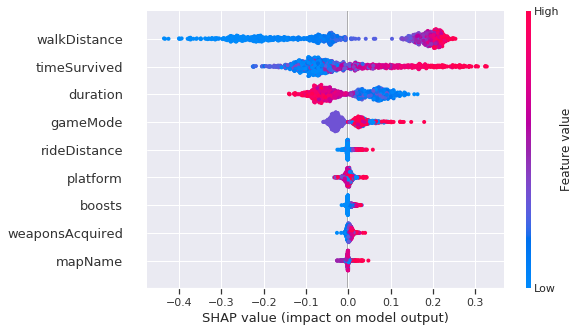

In [32]:
shap.summary_plot(shap_values, observations)

![](https://i.imgur.com/9dpyGCo.png)

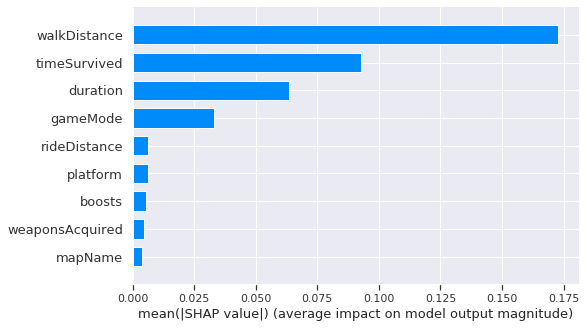

In [33]:
shap.summary_plot(shap_values, observations, plot_type='bar')

![](https://i.imgur.com/5IIfD5b.png)

#### Shap Dependency Plots

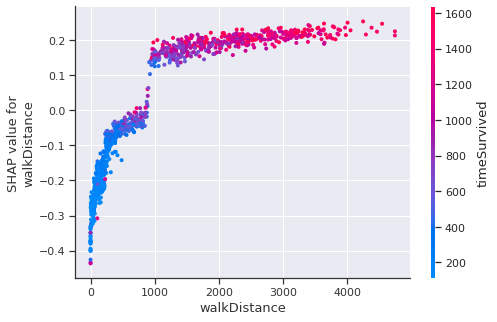

In [34]:
shap.dependence_plot("walkDistance", shap_values, observations)

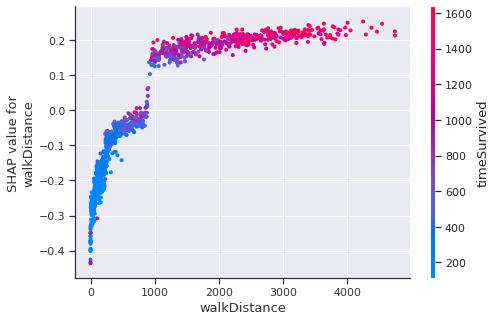

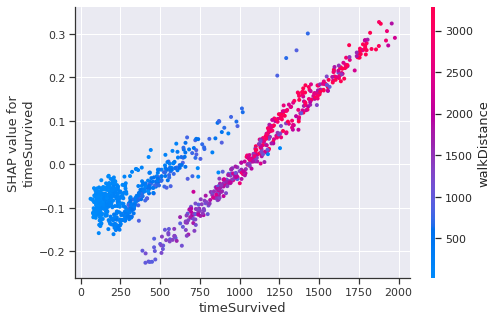

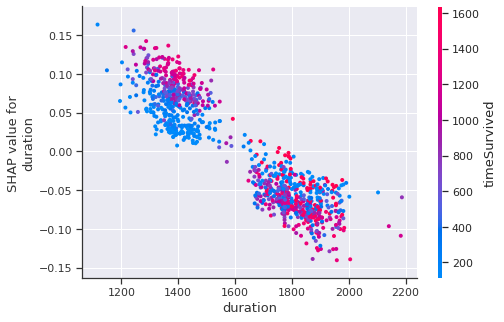

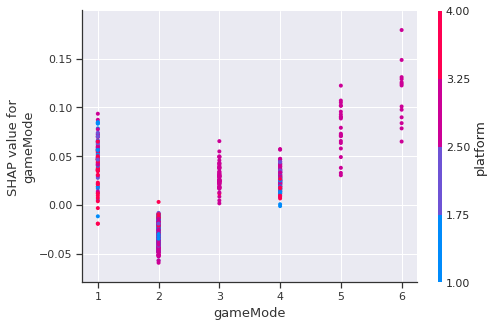

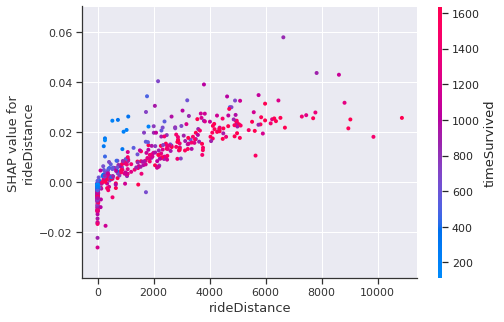

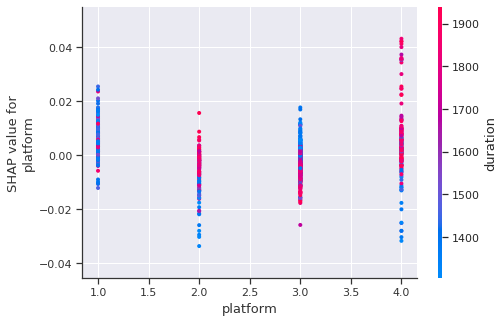

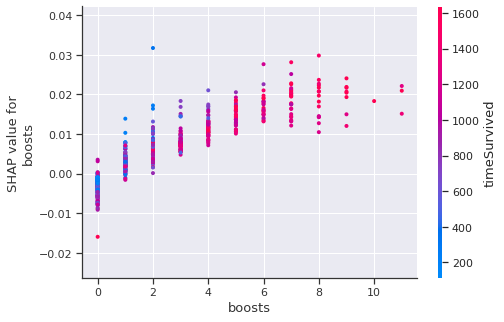

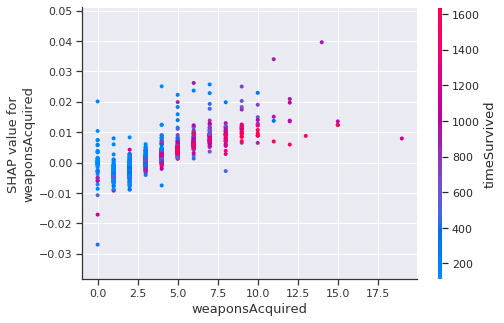

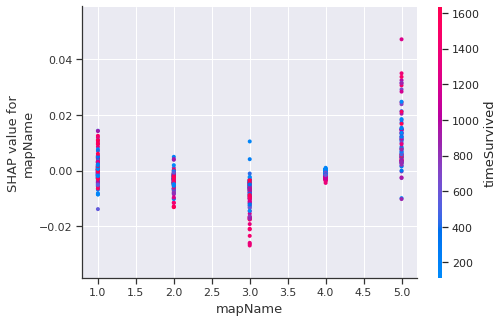

In [35]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(len(top_inds)):
    shap.dependence_plot(top_inds[i], shap_values, observations)

In [36]:
from joblib import load
model_path = '../assets/model/model.joblib'
model = load(model_path)
print('[DEBUG] Model loaded successfully')

def predict(walk_distance, time_survived, duration, game_mode, platform, ride_distance, map_name, weapons_acquired, boosts):

    # Create row
    row = pd.DataFrame(
        columns=['walkDistance', 'timeSurvived', 'duration', 'gameMode',
                 'platform', 'rideDistance', 'mapName', 'weaponsAcquired', 'boosts'],
        data=[[walk_distance, time_survived, duration, game_mode,
               platform, ride_distance, map_name, weapons_acquired, boosts]]
    )
    
    print(row)
    
    y_pred = model.predict(row)[0]
    
    print(y_pred)
    
    output1 = f'Your chances of winning are {y_pred:.2f}%'
    
    
    return output1


walk_distance = 1000
time_survived = 400 
duration = 1000
game_mode = 'squad'
platform = 'steam'
ride_distance = 1000
map_name = 'Erangel_Main'
weapons_acquired = 50
boosts = 1
predict(walk_distance, time_survived, duration, game_mode, platform, ride_distance, map_name, weapons_acquired, boosts)

[DEBUG] Model loaded successfully
   walkDistance  timeSurvived  duration gameMode platform  rideDistance  \
0          1000           400      1000    squad    steam          1000   

        mapName  weaponsAcquired  boosts  
0  Erangel_Main               50       1  
0.4073743396187646


'Your chances of winning are 0.41%'